In [56]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    backtesting_forecaster_multiseries,
    grid_search_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)
from skforecast.plot import set_dark_theme

In [57]:
# Data loading
# ==============================================================================
data = pd.read_csv('../../../data/processed/pivot_table.csv')
df = data.astype({'date': 'datetime64[ns]'})
data = data.set_index('date')
data.head()

,Ananas,Banane,Carotte,Courgette,Lait,Letchi,Poivron,Pomme,Tomate
date,,,,,,,,,
2015-07-27,0.0,626.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-29,0.0,643.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-31,0.0,-159.0,0.0,0.0,671.0,0.0,0.0,0.0,0.0
2015-08-01,0.0,0.0,-512.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-02,0.0,0.0,-57.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Etudier seulement les produits plus frequents
data = data[['Lait', 'Banane', 'Tomate']]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2695 entries, 2015-07-27 to 2025-07-24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Lait    2695 non-null   float64
 1   Banane  2695 non-null   float64
 2   Tomate  2695 non-null   float64
dtypes: float64(3)
memory usage: 84.2+ KB


In [59]:
# Split data into train-val-test
# ==============================================================================
end_train = '2025-01-01 00:00:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 2015-07-27 --- 2025-01-01   (n=2556)
Test dates  : 2025-01-02 --- 2025-07-24   (n=139)


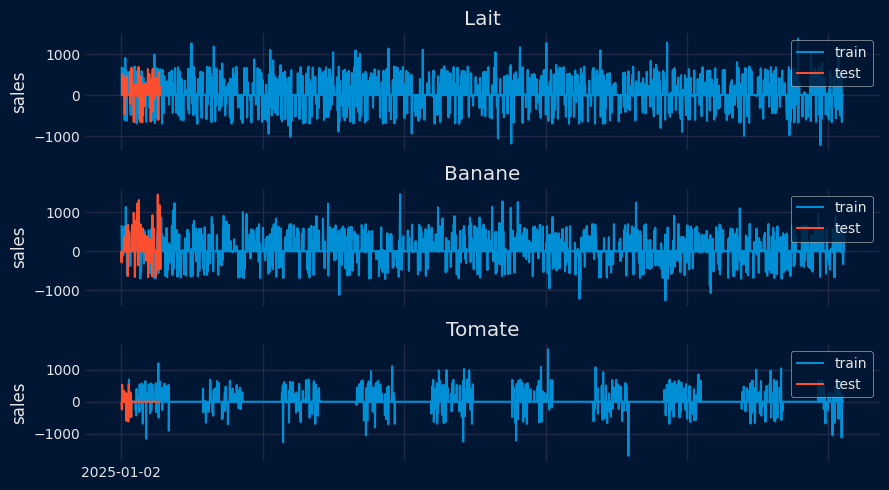

In [63]:
# Plot time series
# ==============================================================================
set_dark_theme()
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)
for i, col in enumerate(data.columns):
    data_train[col].plot(ax=axes[i], label='train')
    data_test[col].plot(ax=axes[i], label='test')
    axes[i].set_title(col)
    axes[i].set_ylabel('sales')
    axes[i].set_xlabel('')
    axes[i].legend(loc='upper right')
fig.tight_layout()
plt.show();

In [64]:
# Create and train ForecasterRecursiveMultiSeries
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 window_features    = RollingFeatures(stats=['mean', 'mean'], window_sizes=[24, 48]),
                 encoding           = 'ordinal',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

forecaster.fit(series=data_train, store_in_sample_residuals=True)
forecaster

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `y.index` is a DatetimeIndex with a frequency or a         │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ c:\Users\ME-PC\Desktop\ERAYDIGITAL\projects\PrediStock\app\data-science-predistock\. │
│ venv\Lib\site-packages\skforecast\utils\utils.py:1402                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_24', 'roll_mean_48'] 
Window size: 48 
Series encoding: ordinal 
Series names (levels): Lait, Banane, Tomate 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'Lait': ['0', '2555'], 'Banane': ['0', '2555'], 'Tomate': ['0', '2555'] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-07-24 11:56:05 
Last fit date: 2025-07-24 11:56:16 
Skforecast version: 0.16.0 
Python version: 3.13.1 
Forecaster id: None

In [66]:
# Predictions and prediction intervals
# ==============================================================================
steps = 24

levels = ['Lait', 'Banane', 'Tomate']

# Predictions for each level
predictions = {}
for level in levels:
    predictions[level] = forecaster.predict(steps=steps, levels=level)
    display(predictions[level].head(3))

# Interval predictions for all levels
predictions_intervals = forecaster.predict_interval(
    steps    = steps,
    levels   = levels,
    method   = "conformal",
    interval = 0.9
)
display(predictions_intervals.head(3))

,level,pred
2556,Lait,75.460424
2557,Lait,78.903436
2558,Lait,43.903606


,level,pred
2556,Banane,32.284758
2557,Banane,71.260201
2558,Banane,16.031064


,level,pred
2556,Tomate,72.412341
2557,Tomate,178.468111
2558,Tomate,32.774124


,level,pred,lower_bound,upper_bound
2556,Lait,75.460424,-301.994446,452.915294
2556,Banane,32.284758,-112.146593,176.716110
2556,Tomate,72.412341,-246.450026,391.274707
